In [ ]:
import numpy as np
import pandas as pd

import os

In [ ]:
data = pd.read_csv('/content/sample_data/ner_datasetreference.csv', encoding='latin1')

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data = data.fillna(method='ffill')

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        agg_function = lambda s: [(w, p, s) for w, p, s in zip(s['Word'].values.tolist(),
                                                              s['POS'].values.tolist(),
                                                              s['Tag'].values.tolist())]

        self.group = self.data.groupby('Sentence #').apply(agg_function)
        self.sentence = [s for s in self.group]

#     def get_next(self,data):


In [ ]:
getter = GetSentence(data)

In [ ]:
sentence = [[word[0] for word in sentence] for sentence in getter.sentence]

In [ ]:
sentence[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [ ]:
labels = [[lab[2] for lab in sentence] for sentence in getter.sentence]

In [ ]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
tag_values = list(set(data["Tag"].values))

In [ ]:
tag_values

['B-org',
 'B-art',
 'B-nat',
 'B-eve',
 'I-art',
 'I-geo',
 'I-eve',
 'I-tim',
 'I-org',
 'I-per',
 'I-gpe',
 'I-nat',
 'B-per',
 'B-gpe',
 'B-geo',
 'B-tim',
 'O']

In [ ]:
tag_values.append('PAD')

In [ ]:
tag_idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_idx

{'B-art': 1,
 'B-eve': 3,
 'B-geo': 14,
 'B-gpe': 13,
 'B-nat': 2,
 'B-org': 0,
 'B-per': 12,
 'B-tim': 15,
 'I-art': 4,
 'I-eve': 6,
 'I-geo': 5,
 'I-gpe': 10,
 'I-nat': 11,
 'I-org': 8,
 'I-per': 9,
 'I-tim': 7,
 'O': 16,
 'PAD': 17}

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
torch.__version__

'1.10.0+cu111'

In [ ]:
 !pip install transformers

     |████████████████████████████████| 3.4 MB 9.0 MB/s 
     |████████████████████████████████| 3.3 MB 49.2 MB/s 
     |████████████████████████████████| 895 kB 65.5 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split

In [ ]:
MAX_LEN = 75
BATCH_SIZE = 16

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(torch.cuda.device_count())

1


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_preserve(sentences,text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentences,text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
  tokenize_preserve(sent,labs)
  for sent,labs in zip(sentence,labels)
]

In [ ]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1]for token_label_pair in tokenized_texts_and_labels]

In [ ]:
len(tokenized_text[0]) , len(labels[0])

(26, 26)

In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                         maxlen=MAX_LEN, dtype='long',value=0.0,
                         truncating='post',padding='post')

In [ ]:
tags = pad_sequences([[tag_idx.get(l)for l in lab]for lab in labels],
                    maxlen=MAX_LEN, dtype='long', value=tag_idx['PAD'],
                    truncating='post',padding='post')

In [ ]:
attention_masks = [[float(i !=0.0)for i in ii]for ii in input_ids]

In [ ]:
tr_input, val_input, tr_tag, val_tag = train_test_split(input_ids,tags,random_state=45,test_size=.1)

In [ ]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=45, test_size=.1)

In [ ]:
len(tr_masks[0]),len(tr_input[0]), len(tr_tag[0])
print(tr_masks[0]), print(tr_input[0]), print(tr_tag[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[10000  2110  4108 19496  1335  5971  1183  1163  1175  1108  1185  6281
  5088  1106 12010   119     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[16 16 12 12  9  9  9 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 1

(None, None, None)

In [ ]:
tr_input = torch.tensor(tr_input)
val_input = torch.tensor(val_input)
tr_tag = torch.tensor(tr_tag)
val_tag = torch.tensor(val_tag)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_input, tr_masks, tr_tag)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(tr_input, tr_masks, tr_tag)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained(
'bert-base-cased',
num_labels=len(tag_idx),
output_attentions = False,
output_hidden_states = False)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
 model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ede33dac2a555ac34f605dedb238ae322b66fc85df27cfabd3ee44d20821eb31
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score

In [ ]:
from tqdm import tqdm, trange

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
#storing loss values
loss_values, validation_loss_values = [], []

#TRAINING AND VALIDATION

for _ in trange(epochs, desc= "Epoch"):
    #/|\==>TRAINLOOP(ONEPASS)<==\|/
    model.train()
    total_loss=0 #so it resets each epoch

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch #also the order in train_data/val_data

        model.zero_grad() #clearing previous gradients for each epoch

        outputs = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask, labels=b_labels)#forward pass

        loss = outputs[0]
        loss.backward() #getting the loss and performing backward pass

        total_loss += loss.item() #tracking loss

        torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=max_grad_norm)
        #^^^ preventing exploding grads

        optimizer.step() #updates parameters

        scheduler.step() #update learning_rate

    avg_train_loss = total_loss/len(train_dataloader)
    print('Average train loss : {}'.format(avg_train_loss))

    loss_values.append(avg_train_loss) #storing loss values if you choose to plot learning curve

    #/|\==>VALIDATION(ONEPASS)<==\|/
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in valid_dataloader:
        batch = tuple(t.to(device)for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids =None,
                           attention_mask=b_input_mask, labels=b_labels)

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print('Validation loss: {}'.format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                for p_i, l_i, in zip(p,l)if tag_values[l_i] !='PAD']

    valid_tags = [tag_values[l_i]for l in true_labels
                 for l_i in l if tag_values[l_i] !='PAD']

    print('Validation Accuracy: {}'.format(accuracy_score(pred_tags,valid_tags)))
    print('Validation F-1 Score:{}'.format(f1_score([pred_tags], [valid_tags])))




Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Average train loss : 0.1748021087744546
Validation loss: 0.10256596072732276
Validation Accuracy: 0.9665325985777204


Epoch:  33%|███▎      | 1/3 [13:33<27:07, 813.74s/it]

Validation F-1 Score:0.8486930504740083
Average train loss : 0.10279924546356684
Validation loss: 0.06652172868764146
Validation Accuracy: 0.9780464652980511


Epoch:  67%|██████▋   | 2/3 [27:07<13:33, 813.85s/it]

Validation F-1 Score:0.8920119239077041
Average train loss : 0.07118215650324196
Validation loss: 0.0494091529074678
Validation Accuracy: 0.9838364792010681


Epoch: 100%|██████████| 3/3 [40:41<00:00, 813.84s/it]

Validation F-1 Score:0.9181601399687908


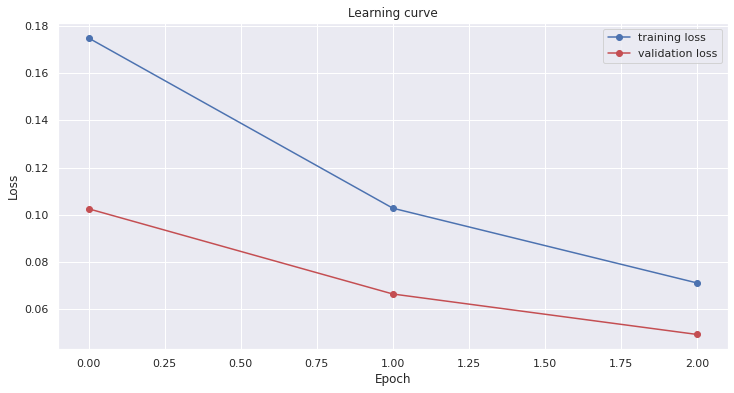

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentence = """Hello, my name is Jonathan and I live in Chicago along with my girlfriend Paige and my dog Goose.
Paige and myself are interested in moving to North Carolina, Tennessee, Washington, or Colorado if we get the opportunity.
I hope to work as a data scientist, and Paige wants to be the Hokage of the Hidden Leaf Village."""

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
with torch.no_grad():
    output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(),axis=2)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

new_tokens, new_labels = [], []

for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith('##'):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print('{}\t{}'.format(label,token))

O	[CLS]
B-tim	Hello
O	,
O	my
O	name
O	is
B-per	Jonathan
O	and
O	I
O	live
O	in
B-geo	Chicago
O	along
O	with
O	my
O	girlfriend
B-per	Paige
O	and
O	my
O	dog
O	Goose
O	.
B-per	Paige
O	and
O	myself
O	are
O	interested
O	in
O	moving
O	to
B-geo	North
I-geo	Carolina
O	,
B-geo	Tennessee
O	,
B-geo	Washington
O	,
O	or
B-geo	Colorado
O	if
O	we
O	get
O	the
O	opportunity
O	.
O	I
O	hope
O	to
O	work
O	as
O	a
O	data
O	scientist
O	,
O	and
B-per	Paige
O	wants
O	to
O	be
O	the
B-org	Hokage
O	of
O	the
B-org	Hidden
I-org	Leaf
I-org	Village
O	.
O	[SEP]
